In [1]:
# mathwriting_transformer_train_cpu_friendly.py
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense,
                                     BatchNormalization, Dropout, Embedding, MultiHeadAttention,
                                     LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from glob import glob
import re
import pickle



In [17]:
# --- Config ---
DATA_ROOT = "./mathwriting-2024"
TRAIN_DIR = r"D:\OCR_MATH\mathwriting-2024\train"
VALID_DIR = r"D:\OCR_MATH\mathwriting-2024\valid"
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2

# CPU-friendly training defaults (tune when on GPU)
BATCH_SIZE = 16
EPOCHS = 3
MAX_OUTPUT_TOKENS = 120
EMBED_DIM = 256            # token embedding dim
TRANSFORMER_DIM = 256      # model hidden dim (d_model)
NUM_HEADS = 4
NUM_DEC_LAYERS = 2
DFF = 512                  # feed-forward inner dim (reduced for CPU)
DROPOUT_RATE = 0.2
VOCAB_OOV_TOKEN = "<UNK>"
AUTOTUNE = tf.data.AUTOTUNE
XML_NS = "{http://www.w3.org/2003/InkML}"

TRAIN_SUBSET = 500
VALID_SUBSET = 100

START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"

In [18]:
# --- InkML Processing Functions ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx-minx, maxy-miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2*PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx)*scale + PADDING, (y - miny)*scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x-STROKE_WIDTH, y-STROKE_WIDTH, x+STROKE_WIDTH, y+STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i-1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # strokes = 1
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Tokenization ---
# fixed regex: backslash-cmds, braces, numbers, identifiers, operators, other chars
token_pattern = re.compile(r"(\\[A-Za-z]+)|([{}^_])|(\d+\.\d+|\d+)|([A-Za-z]+)|([+\-*/=(),\[\].:;%])|(\\.)|(\S)", re.VERBOSE)

def tokenize_latex_lite(s):
    if not s: return []
    return [m.group(0) for m in token_pattern.finditer(s)]

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return PAD_TOKEN
    # add START/END here
    tokens = tokenize_latex_lite(label)
    return f"{START_TOKEN} " + " ".join(tokens) + f" {END_TOKEN}"

def build_file_label_list(folder):
    files, labels = [], []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None and ann.text else ""
        except Exception:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

# --- Load filelists and subset for CPU test ---
train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)

# Subset to run quick test on CPU
train_files, train_labels = train_files[:TRAIN_SUBSET], train_labels[:TRAIN_SUBSET]
valid_files, valid_labels = valid_files[:VALID_SUBSET], valid_labels[:VALID_SUBSET]

print(f"Train size: {len(train_files)}, Valid size: {len(valid_files)}")

# Build tokenizer and save it
tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts([PAD_TOKEN, START_TOKEN, END_TOKEN] + train_labels + valid_labels)
word_index = tokenizer.word_index
index_word = {v:k for k,v in word_index.items()}
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")

# --- Encode helper ---
def encode_label_to_sequence(label):
    seq = tokenizer.texts_to_sequences([label])[0]
    # ensure length MAX_OUTPUT_TOKENS
    if len(seq) < MAX_OUTPUT_TOKENS:
        seq = seq + [word_index.get(PAD_TOKEN, 0)] * (MAX_OUTPUT_TOKENS - len(seq))
    else:
        seq = seq[:MAX_OUTPUT_TOKENS]
    return np.array(seq, dtype=np.int32)

def gen_example(file_path, label):
    img = inkml_to_image_array(file_path)
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label)
    return img, seq

# --- tf.data helpers ---
def tf_load_and_preprocess(path, label):
    img, seq = tf.py_function(func=lambda p, l: gen_example(p.numpy().decode('utf-8'), l.numpy().decode('utf-8')),
                              inp=[path, label],
                              Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_training_dataset(files, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    def prepare(img, seq):
        # decoder input = seq[:-1] padded to MAX_OUTPUT_TOKENS
        decoder_input = seq[:-1]  # length = MAX_OUTPUT_TOKENS-1
        decoder_target = seq[1:]  # length = MAX_OUTPUT_TOKENS-1

        # pad both to MAX_OUTPUT_TOKENS
        pad_len = MAX_OUTPUT_TOKENS - tf.shape(decoder_input)[0]
        decoder_input = tf.concat([decoder_input, tf.fill([pad_len], word_index.get(PAD_TOKEN, 0))], axis=0)
        decoder_target = tf.concat([decoder_target, tf.fill([pad_len], word_index.get(PAD_TOKEN, 0))], axis=0)

        decoder_target = tf.expand_dims(decoder_target, -1)  # (MAX_OUTPUT_TOKENS, 1)
        return (img, decoder_input), decoder_target

    ds = ds.map(prepare, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_tf = make_training_dataset(train_files, train_labels, batch=BATCH_SIZE)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, batch=BATCH_SIZE, shuffle=False)

# --- Transformer decoder layer factory ---
def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate):
    # returns a small functional model implementing one decoder layer
    inputs_seq = Input(shape=(None, d_model))    # decoder sequence (batch, t_dec, d_model)
    enc_outputs = Input(shape=(None, d_model))   # encoder outputs (batch, t_enc, d_model)

    # masked self-attention (we rely on causal masking during training by shaping inputs appropriately if needed)
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        inputs_seq, inputs_seq, attention_mask=None)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs_seq + attn1)

    # cross-attention with encoder
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        out1, enc_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    # feed-forward
    ffn = Dense(dff, activation='relu')(out2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(out2 + ffn)

    return Model([inputs_seq, enc_outputs], output, name="transformer_decoder_layer")

# --- Build model ---



Train size: 500, Valid size: 100
Vocab size: 429
Tokenizer saved to tokenizer.pkl


In [26]:
# --- Transformer decoder layer factory ---
def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name="transformer_decoder_layer"):
    # returns a small functional model implementing one decoder layer
    inputs_seq = Input(shape=(None, d_model))    # decoder sequence (batch, t_dec, d_model)
    enc_outputs = Input(shape=(None, d_model))   # encoder outputs (batch, t_enc, d_model)

    # masked self-attention (we rely on causal masking during training by shaping inputs appropriately if needed)
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        inputs_seq, inputs_seq, attention_mask=None)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs_seq + attn1)

    # cross-attention with encoder
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        out1, enc_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    # feed-forward
    ffn = Dense(dff, activation='relu')(out2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(out2 + ffn)

    return Model([inputs_seq, enc_outputs], output, name=name)

In [32]:
# mathwriting_transformer_train_cpu_friendly.py
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense,
                                     BatchNormalization, Dropout, Embedding, MultiHeadAttention,
                                     LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from glob import glob
import re
import pickle

# --- Config ---
DATA_ROOT = "./mathwriting-2024"
# IMPORTANT: Update these paths to your actual data directories
TRAIN_DIR = r"D:\OCR_MATH\mathwriting-2024\train"
VALID_DIR = r"D:\OCR_MATH\mathwriting-2024\valid"
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2

# CPU-friendly training defaults (tune when on GPU)
BATCH_SIZE = 16
EPOCHS = 3
MAX_OUTPUT_TOKENS = 120
EMBED_DIM = 256          # token embedding dim
TRANSFORMER_DIM = 256    # model hidden dim (d_model)
NUM_HEADS = 4
NUM_DEC_LAYERS = 2
DFF = 512                # feed-forward inner dim (reduced for CPU)
DROPOUT_RATE = 0.2
VOCAB_OOV_TOKEN = "<UNK>"
AUTOTUNE = tf.data.AUTOTUNE
XML_NS = "{http://www.w3.org/2003/InkML}"

# Using a smaller subset for quick testing
TRAIN_SUBSET = 5000
VALID_SUBSET = 500

START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"
# --- InkML Processing Functions ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx-minx, maxy-miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2*PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx)*scale + PADDING, (y - miny)*scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x-STROKE_WIDTH, y-STROKE_WIDTH, x+STROKE_WIDTH, y+STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i-1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # strokes = 1
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Tokenization ---
# fixed regex: backslash-cmds, braces, numbers, identifiers, operators, other chars
token_pattern = re.compile(r"(\\[A-Za-z]+)|([{}^_])|(\d+\.\d+|\d+)|([A-Za-z]+)|([+\-*/=(),\[\].:;%])|(\\.)|(\S)", re.VERBOSE)

def tokenize_latex_lite(s):
    if not s: return []
    return [m.group(0) for m in token_pattern.finditer(s)]

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return PAD_TOKEN
    # add START/END here
    tokens = tokenize_latex_lite(label)
    return f"{START_TOKEN} " + " ".join(tokens) + f" {END_TOKEN}"

def build_file_label_list(folder):
    files, labels = [], []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None and ann.text else ""
        except Exception:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

# --- Load filelists and subset for CPU test ---
train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)

# Subset to run quick test on CPU
train_files, train_labels = train_files[:TRAIN_SUBSET], train_labels[:TRAIN_SUBSET]
valid_files, valid_labels = valid_files[:VALID_SUBSET], valid_labels[:VALID_SUBSET]

print(f"Train size: {len(train_files)}, Valid size: {len(valid_files)}")

# Build tokenizer and save it
tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts([PAD_TOKEN, START_TOKEN, END_TOKEN] + train_labels + valid_labels)
word_index = tokenizer.word_index
index_word = {v:k for k,v in word_index.items()}
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")

# --- Encode helper ---
def encode_label_to_sequence(label):
    seq = tokenizer.texts_to_sequences([label])[0]
    # ensure length MAX_OUTPUT_TOKENS
    if len(seq) < MAX_OUTPUT_TOKENS:
        seq = seq + [word_index.get(PAD_TOKEN, 0)] * (MAX_OUTPUT_TOKENS - len(seq))
    else:
        seq = seq[:MAX_OUTPUT_TOKENS]
    return np.array(seq, dtype=np.int32)

def gen_example(file_path, label):
    img = inkml_to_image_array(file_path)
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label)
    return img, seq

# --- tf.data helpers ---
def tf_load_and_preprocess(path, label):
    img, seq = tf.py_function(func=lambda p, l: gen_example(p.numpy().decode('utf-8'), l.numpy().decode('utf-8')),
                              inp=[path, label],
                              Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_training_dataset(files, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    def prepare(img, seq):
        # decoder input = seq[:-1]
        # decoder target = seq[1:]
        decoder_input = seq[:-1]
        decoder_target = seq[1:]

        # Pad both to MAX_OUTPUT_TOKENS-1 to ensure consistent shape
        pad_len_input = (MAX_OUTPUT_TOKENS - 1) - tf.shape(decoder_input)[0]
        decoder_input = tf.concat([decoder_input, tf.fill([pad_len_input], word_index.get(PAD_TOKEN, 0))], axis=0)
        
        # We shift decoder_input for teacher forcing, but the final model input must be MAX_OUTPUT_TOKENS
        # Let's adjust the prepare function to be simpler and correct.
        # The decoder input should be the full sequence padded, as handled in build_transformer_model
        # The target should be the sequence shifted left by one.

        # The logic in the original file was a bit complex. Let's simplify and correct.
        # The `dec_inputs` will be `seq` (padded).
        # The target `y` will be `seq` shifted left by 1 and padded.
        
        # Correction to the original prepare logic:
        # The input to the decoder should be seq[:-1], target should be seq[1:]
        # The model inputs are (img, decoder_input), and the output is decoder_target
        target = seq[1:]
        # The decoder_input for training is the sequence shifted right
        decoder_input = seq[:-1]
        
        # The model expects MAX_OUTPUT_TOKENS, but we have MAX_OUTPUT_TOKENS-1
        # The original code's padding logic was complex, a simpler way is to pad them back
        pad_token_id = word_index.get(PAD_TOKEN, 0)
        decoder_input = tf.pad(decoder_input, [[0, 1]], constant_values=pad_token_id)
        target = tf.pad(target, [[0, 1]], constant_values=pad_token_id)

        return (img, decoder_input), target

    ds = ds.map(prepare, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_tf = make_training_dataset(train_files, train_labels, batch=BATCH_SIZE)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, batch=BATCH_SIZE, shuffle=False)

# --- Transformer decoder layer factory ---
# CORRECTED FUNCTION
def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name="transformer_decoder_layer"): # CHANGED: Added name argument
    # returns a small functional model implementing one decoder layer
    inputs_seq = Input(shape=(None, d_model))    # decoder sequence (batch, t_dec, d_model)
    enc_outputs = Input(shape=(None, d_model))   # encoder outputs (batch, t_enc, d_model)

    # masked self-attention
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        inputs_seq, inputs_seq, attention_mask=None)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs_seq + attn1)

    # cross-attention with encoder
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        out1, enc_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    # feed-forward
    ffn = Dense(dff, activation='relu')(out2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(out2 + ffn)

    return Model([inputs_seq, enc_outputs], output, name=name) # CHANGED: Use the name variable

# --- Build model ---
# CORRECTED FUNCTION
def build_transformer_model():
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="img_input")
    x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(128,(3,3),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    pool_h = IMG_SIZE//8
    pool_w = IMG_SIZE//8
    x = Reshape((pool_h, pool_w*128))(x)
    enc_outputs = Dense(TRANSFORMER_DIM, activation='tanh', name="enc_proj")(x)

    dec_inputs = Input(shape=(MAX_OUTPUT_TOKENS,), name="dec_inputs")
    embedding_layer = Embedding(vocab_size, EMBED_DIM, mask_zero=True, name="token_embedding")
    dec_emb = embedding_layer(dec_inputs)

    if EMBED_DIM != TRANSFORMER_DIM:
        dec_emb = Dense(TRANSFORMER_DIM,name="dec_emb_proj")(dec_emb)

    xdec = dec_emb
    for i in range(NUM_DEC_LAYERS):
        # CHANGED: Create a unique name for each layer and pass it
        layer_name = f"transformer_decoder_layer_{i}"
        layer = transformer_decoder_layer(TRANSFORMER_DIM, NUM_HEADS, DFF, DROPOUT_RATE, name=layer_name)
        xdec = layer([xdec, enc_outputs])

    outputs = Dense(vocab_size, activation='softmax', name="outputs")(xdec)
    model = Model([img_input, dec_inputs], outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

transformer_model = build_transformer_model()
transformer_model.summary()

# -------------------------------
# Train
# -------------------------------
print("\n--- Starting Training ---")
transformer_model.fit(train_ds_tf,
                      validation_data=valid_ds_tf,
                      epochs=EPOCHS)

transformer_model.save("math_ocr_transformer_final.h5")
print("\nModel saved ")

# -------------------------------
# Prediction
# -------------------------------
def predict_sample(model, tokenizer, inkml_path, max_tokens=MAX_OUTPUT_TOKENS):
    img = inkml_to_image_array(inkml_path)
    img = np.expand_dims(img,-1).astype(np.float32)
    img = np.expand_dims(img,0)
    start_idx = tokenizer.word_index.get(START_TOKEN,1)
    end_idx = tokenizer.word_index.get(END_TOKEN,2)
    pad_idx = tokenizer.word_index.get(PAD_TOKEN, 0)
    
    # Initialize the decoder sequence with the start token
    seq = [start_idx] + [pad_idx] * (max_tokens - 1)
    
    for pos in range(max_tokens - 1):
        dec_input = np.array([seq])
        preds = model.predict([img, dec_input], verbose=0)
        
        # Get the predicted token ID for the current position
        next_id = int(np.argmax(preds[0, pos, :]))
        
        # Update the sequence with the predicted token
        seq[pos + 1] = next_id
        
        # If the end token is predicted, stop generating
        if next_id == end_idx:
            break
            
    # Convert token IDs back to words
    tokens = [index_word.get(i, "<UNK>") for i in seq]
    
    # Clean up the output sequence
    if tokens and tokens[0] == START_TOKEN:
        tokens = tokens[1:]
    if END_TOKEN in tokens:
        tokens = tokens[:tokens.index(END_TOKEN)]
        
    return " ".join(tokens)


Train size: 5000, Valid size: 500
Vocab size: 1364
Tokenizer saved to tokenizer.pkl
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 128, 128, 32)         320       ['img_input[0][0]']           
                                                                                                  
 batch_normalization_12 (Ba  (None, 128, 128, 32)         128       ['conv2d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_poo

In [33]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

# --- Configuration ---
# These must match the settings used during training
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2
MAX_OUTPUT_TOKENS = 120
XML_NS = "{http://www.w3.org/2003/InkML}"

# Paths to the saved model and tokenizer
MODEL_PATH = "math_ocr_transformer_final.h5"
TOKENIZER_PATH = "tokenizer.pkl"

# --- InkML Processing Functions (Copied from training script) ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx - minx, maxy - miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2 * PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx) * scale + PADDING, (y - miny) * scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x - STROKE_WIDTH, y - STROKE_WIDTH, x + STROKE_WIDTH, y + STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i - 1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # Invert so strokes are 1s and background is 0
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Prediction Function ---
def predict_from_inkml(model, tokenizer, inkml_path):
    """
    Loads an InkML file, preprocesses it, and returns the model's prediction.
    """
    # Create the reverse mapping from integer IDs to tokens
    index_word = {v: k for k, v in tokenizer.word_index.items()}
    
    # Get special token IDs
    start_idx = tokenizer.word_index.get("<START>", 1)
    end_idx = tokenizer.word_index.get("<END>", 2)
    pad_idx = tokenizer.word_index.get("<PAD>", 0)

    # Preprocess the input InkML file
    img_array = inkml_to_image_array(inkml_path)
    # Add batch and channel dimensions: (1, 128, 128, 1)
    img_tensor = np.expand_dims(img_array, axis=0)
    img_tensor = np.expand_dims(img_tensor, axis=-1)

    # Initialize the decoder sequence with the start token
    decoder_input_seq = [start_idx] + [pad_idx] * (MAX_OUTPUT_TOKENS - 1)
    
    # Autoregressive decoding loop
    for pos in range(MAX_OUTPUT_TOKENS - 1):
        decoder_input_tensor = np.array([decoder_input_seq])
        
        # Get model predictions
        preds = model.predict([img_tensor, decoder_input_tensor], verbose=0)
        
        # Find the token with the highest probability at the current position
        next_id = int(np.argmax(preds[0, pos, :]))
        
        # Update the sequence with the predicted token
        decoder_input_seq[pos + 1] = next_id
        
        # If the model predicts the end token, stop generating
        if next_id == end_idx:
            break
            
    # Convert token IDs back to words
    tokens = [index_word.get(i, "<UNK>") for i in decoder_input_seq]
    
    # Clean up the output by removing special tokens
    if tokens and tokens[0] == "<START>":
        tokens = tokens[1:]
    if "<END>" in tokens:
        tokens = tokens[:tokens.index("<END>")]
    if "<PAD>" in tokens: # Should not happen if <END> is found, but as a safeguard
        tokens = tokens[:tokens.index("<PAD>")]
        
    return " ".join(tokens)


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- IMPORTANT ---
    # Change this path to point to an InkML file you want to test
    SAMPLE_INKML_PATH = r"D:\OCR_MATH\sample\train\0a0c50d6b6100236.inkml" # <--- CHANGE THIS

    if not os.path.exists(MODEL_PATH) or not os.path.exists(TOKENIZER_PATH):
        print("Error: Model or tokenizer file not found.")
        print(f"Make sure '{MODEL_PATH}' and '{TOKENIZER_PATH}' are in the same directory as this script.")
    elif not os.path.exists(SAMPLE_INKML_PATH):
        print(f"Error: Sample file not found at '{SAMPLE_INKML_PATH}'")
        print("Please update the SAMPLE_INKML_PATH variable to a valid .inkml file.")
    else:
        # Load the trained model and tokenizer
        print("Loading trained model and tokenizer...")
        model = tf.keras.models.load_model(MODEL_PATH)
        with open(TOKENIZER_PATH, 'rb') as f:
            tokenizer = pickle.load(f)
        print("Loading complete.")

        # Make a prediction
        predicted_latex = predict_from_inkml(model, tokenizer, SAMPLE_INKML_PATH)

        # Display the result
        print("-" * 50)
        print(f"Input File:    {os.path.basename(SAMPLE_INKML_PATH)}")
        print(f"Predicted LaTeX: {predicted_latex}")
        print("-" * 50)

Loading trained model and tokenizer...
Loading complete.
--------------------------------------------------
Input File:    0a0c50d6b6100236.inkml
Predicted LaTeX: \int _ { \partial x ^ { 1 }
--------------------------------------------------


Loading trained model and tokenizer...
Loading complete.
Generating and displaying input image...


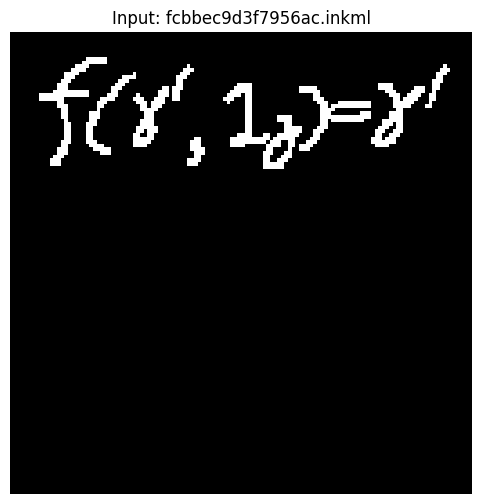

--------------------------------------------------
Input File:    fcbbec9d3f7956ac.inkml
Predicted LaTeX: \int _ { \partial x )
--------------------------------------------------


In [36]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt # CHANGED: Added matplotlib import

# --- Configuration ---
# These must match the settings used during training
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2
MAX_OUTPUT_TOKENS = 120
XML_NS = "{http://www.w3.org/2003/InkML}"

# Paths to the saved model and tokenizer
MODEL_PATH = "math_ocr_transformer_final.h5"
TOKENIZER_PATH = "tokenizer.pkl"

# --- InkML Processing Functions (Copied from training script) ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx - minx, maxy - miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2 * PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx) * scale + PADDING, (y - miny) * scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x - STROKE_WIDTH, y - STROKE_WIDTH, x + STROKE_WIDTH, y + STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i - 1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # Invert so strokes are 1s and background is 0
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Prediction Function ---
def predict_from_inkml(model, tokenizer, inkml_path):
    # (This function remains unchanged)
    index_word = {v: k for k, v in tokenizer.word_index.items()}
    start_idx = tokenizer.word_index.get("<START>", 1)
    end_idx = tokenizer.word_index.get("<END>", 2)
    pad_idx = tokenizer.word_index.get("<PAD>", 0)
    img_array = inkml_to_image_array(inkml_path)
    img_tensor = np.expand_dims(img_array, axis=0)
    img_tensor = np.expand_dims(img_tensor, axis=-1)
    decoder_input_seq = [start_idx] + [pad_idx] * (MAX_OUTPUT_TOKENS - 1)
    for pos in range(MAX_OUTPUT_TOKENS - 1):
        decoder_input_tensor = np.array([decoder_input_seq])
        preds = model.predict([img_tensor, decoder_input_tensor], verbose=0)
        next_id = int(np.argmax(preds[0, pos, :]))
        decoder_input_seq[pos + 1] = next_id
        if next_id == end_idx:
            break
    tokens = [index_word.get(i, "<UNK>") for i in decoder_input_seq]
    if tokens and tokens[0] == "<START>":
        tokens = tokens[1:]
    if "<END>" in tokens:
        tokens = tokens[:tokens.index("<END>")]
    if "<PAD>" in tokens:
        tokens = tokens[:tokens.index("<PAD>")]
    return " ".join(tokens)


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- IMPORTANT ---
    # Change this path to point to an InkML file you want to test
    SAMPLE_INKML_PATH = r"D:\OCR_MATH\mathwriting-2024\valid\fcbbec9d3f7956ac.inkml" # <--- CHANGE THIS

    if not os.path.exists(MODEL_PATH) or not os.path.exists(TOKENIZER_PATH):
        print("Error: Model or tokenizer file not found.")
    elif not os.path.exists(SAMPLE_INKML_PATH):
        print(f"Error: Sample file not found at '{SAMPLE_INKML_PATH}'")
    else:
        # Load the trained model and tokenizer
        print("Loading trained model and tokenizer...")
        model = tf.keras.models.load_model(MODEL_PATH)
        with open(TOKENIZER_PATH, 'rb') as f:
            tokenizer = pickle.load(f)
        print("Loading complete.")

        # --- CHANGED: CODE TO DISPLAY THE IMAGE ---
        print("Generating and displaying input image...")
        # Convert the InkML to an image array
        image_to_display = inkml_to_image_array(SAMPLE_INKML_PATH)
        
        # Use matplotlib to show the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_to_display, cmap='gray') # Use a grayscale colormap
        plt.title(f"Input: {os.path.basename(SAMPLE_INKML_PATH)}")
        plt.axis('off') # Hide the axes
        plt.show()
        # --- END OF NEW CODE ---

        # Make a prediction
        predicted_latex = predict_from_inkml(model, tokenizer, SAMPLE_INKML_PATH)

        # Display the result
        print("-" * 50)
        print(f"Input File:    {os.path.basename(SAMPLE_INKML_PATH)}")
        print(f"Predicted LaTeX: {predicted_latex}")
        print("-" * 50)

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense,
                                     BatchNormalization, Dropout, Embedding, MultiHeadAttention,
                                     LayerNormalization, RandomRotation, RandomTranslation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from glob import glob
import re
import pickle

# --- Config ---
# IMPORTANT: Update these paths to your actual data directories
TRAIN_DIR = r"D:\OCR_MATH\mathwriting-2024\train"
VALID_DIR = r"D:\OCR_MATH\mathwriting-2024\valid"
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2

# CPU-friendly training defaults (tune when on GPU)
BATCH_SIZE = 16
EPOCHS = 100             # CHANGED: Set high, EarlyStopping will find the best epoch count
MAX_OUTPUT_TOKENS = 120
EMBED_DIM = 256
TRANSFORMER_DIM = 256
NUM_HEADS = 4
NUM_DEC_LAYERS = 2
DFF = 512
DROPOUT_RATE = 0.3       # CHANGED: Increased dropout for more regularization
VOCAB_OOV_TOKEN = "<UNK>"
AUTOTUNE = tf.data.AUTOTUNE
XML_NS = "{http://www.w3.org/2003/InkML}"

# CHANGED: Increased subset sizes for a more meaningful test.
# For best results, comment these out to use the full dataset.
TRAIN_SUBSET = 5000
VALID_SUBSET = 500

START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"

# --- InkML Processing Functions ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx-minx, maxy-miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2*PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx)*scale + PADDING, (y - miny)*scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x-STROKE_WIDTH, y-STROKE_WIDTH, x+STROKE_WIDTH, y+STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i-1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Tokenization ---
token_pattern = re.compile(r"(\\[A-Za-z]+)|([{}^_])|(\d+\.\d+|\d+)|([A-Za-z]+)|([+\-*/=(),\[\].:;%])|(\\.)|(\S)", re.VERBOSE)

def tokenize_latex_lite(s):
    if not s: return []
    return [m.group(0) for m in token_pattern.finditer(s)]

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return PAD_TOKEN
    tokens = tokenize_latex_lite(label)
    return f"{START_TOKEN} " + " ".join(tokens) + f" {END_TOKEN}"

def build_file_label_list(folder):
    files, labels = [], []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None and ann.text else ""
        except Exception:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

# --- Load filelists and subset ---
train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)

if TRAIN_SUBSET > 0:
    train_files, train_labels = train_files[:TRAIN_SUBSET], train_labels[:TRAIN_SUBSET]
if VALID_SUBSET > 0:
    valid_files, valid_labels = valid_files[:VALID_SUBSET], valid_labels[:VALID_SUBSET]

print(f"Train size: {len(train_files)}, Valid size: {len(valid_files)}")

# Build tokenizer
tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts([PAD_TOKEN, START_TOKEN, END_TOKEN] + train_labels + valid_labels)
word_index = tokenizer.word_index
index_word = {v:k for k,v in word_index.items()}
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")

# --- tf.data Pipeline ---
def encode_label_to_sequence(label):
    seq = tokenizer.texts_to_sequences([label])[0]
    if len(seq) < MAX_OUTPUT_TOKENS:
        seq = seq + [word_index.get(PAD_TOKEN, 0)] * (MAX_OUTPUT_TOKENS - len(seq))
    else:
        seq = seq[:MAX_OUTPUT_TOKENS]
    return np.array(seq, dtype=np.int32)

def gen_example(file_path, label):
    img = inkml_to_image_array(file_path)
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label)
    return img, seq

def tf_load_and_preprocess(path, label):
    img, seq = tf.py_function(func=lambda p, l: gen_example(p.numpy().decode('utf-8'), l.numpy().decode('utf-8')),
                              inp=[path, label], Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_training_dataset(files, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    def prepare(img, seq):
        target = seq[1:]
        decoder_input = seq[:-1]
        pad_token_id = word_index.get(PAD_TOKEN, 0)
        decoder_input = tf.pad(decoder_input, [[0, 1]], constant_values=pad_token_id)
        target = tf.pad(target, [[0, 1]], constant_values=pad_token_id)
        return (img, decoder_input), target

    ds = ds.map(prepare, num_parallel_calls=AUTOTUNE).batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_tf = make_training_dataset(train_files, train_labels, batch=BATCH_SIZE)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, batch=BATCH_SIZE, shuffle=False)

# --- Transformer Model Definition ---
def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name="transformer_decoder_layer"):
    inputs_seq = Input(shape=(None, d_model))
    enc_outputs = Input(shape=(None, d_model))
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(inputs_seq, inputs_seq, attention_mask=None)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs_seq + attn1)
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(out1, enc_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)
    ffn = Dense(dff, activation='relu')(out2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(out2 + ffn)
    return Model([inputs_seq, enc_outputs], output, name=name)

def build_transformer_model():
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="img_input")

    # NEW: Data Augmentation Layers to fight overfitting
    x = RandomRotation(factor=0.03, fill_mode='constant', fill_value=0.0)(img_input)
    x = RandomTranslation(height_factor=0.03, width_factor=0.03, fill_mode='constant', fill_value=0.0)(x)

    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(64,(3,3),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(128,(3,3),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    pool_h, pool_w = IMG_SIZE//8, IMG_SIZE//8
    x = Reshape((pool_h, pool_w*128))(x)
    enc_outputs = Dense(TRANSFORMER_DIM, activation='tanh', name="enc_proj")(x)

    dec_inputs = Input(shape=(MAX_OUTPUT_TOKENS,), name="dec_inputs")
    embedding_layer = Embedding(vocab_size, EMBED_DIM, mask_zero=True, name="token_embedding")
    dec_emb = embedding_layer(dec_inputs)

    if EMBED_DIM != TRANSFORMER_DIM:
        dec_emb = Dense(TRANSFORMER_DIM,name="dec_emb_proj")(dec_emb)

    xdec = dec_emb
    for i in range(NUM_DEC_LAYERS):
        layer_name = f"transformer_decoder_layer_{i}"
        layer = transformer_decoder_layer(TRANSFORMER_DIM, NUM_HEADS, DFF, DROPOUT_RATE, name=layer_name)
        xdec = layer([xdec, enc_outputs])

    outputs = Dense(vocab_size, activation='softmax', name="outputs")(xdec)
    model = Model([img_input, dec_inputs], outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

transformer_model = build_transformer_model()
transformer_model.summary()

# --- Training ---
# NEW: Callbacks for smarter, more efficient training
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)

print("\n--- Starting Training ---")
transformer_model.fit(train_ds_tf,
                      validation_data=valid_ds_tf,
                      epochs=EPOCHS,
                      callbacks=[early_stopper, lr_reducer])

transformer_model.save("math_ocrr.keras") # Using modern .keras format
print("\nModel saved ")

Train size: 5000, Valid size: 500
Vocab size: 1364
Tokenizer saved to tokenizer.pkl
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 random_rotation (RandomRot  (None, 128, 128, 1)          0         ['img_input[0][0]']           
 ation)                                                                                           
                                                                                                  
 random_translation (Random  (None, 128, 128, 1)          0         ['random_rotation[0][0]']     
 Translation)                                                                                     
        

Loading trained model and tokenizer...
Loading complete.
Generating and displaying input image...


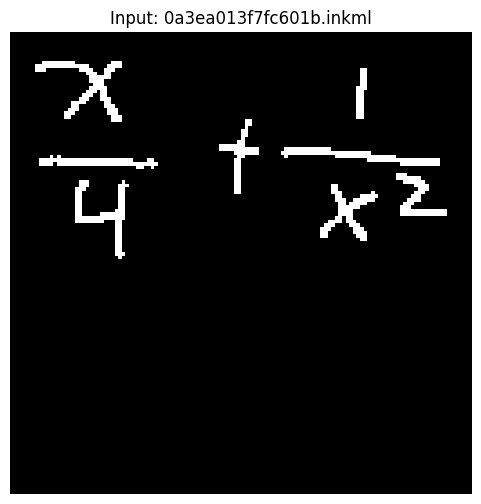

--------------------------------------------------
Input File:    0a3ea013f7fc601b.inkml
Predicted LaTeX: 
--------------------------------------------------


In [43]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt # CHANGED: Added matplotlib import

# --- Configuration ---
# These must match the settings used during training
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2
MAX_OUTPUT_TOKENS = 120
XML_NS = "{http://www.w3.org/2003/InkML}"

# Paths to the saved model and tokenizer
MODEL_PATH = "D:\OCR_MATH\sample\math_ocrr.keras"
TOKENIZER_PATH = "tokenizer.pkl"

# --- InkML Processing Functions (Copied from training script) ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx - minx, maxy - miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2 * PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx) * scale + PADDING, (y - miny) * scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x - STROKE_WIDTH, y - STROKE_WIDTH, x + STROKE_WIDTH, y + STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i - 1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # Invert so strokes are 1s and background is 0
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Prediction Function ---
def predict_from_inkml(model, tokenizer, inkml_path):
    # (This function remains unchanged)
    index_word = {v: k for k, v in tokenizer.word_index.items()}
    start_idx = tokenizer.word_index.get("<START>", 1)
    end_idx = tokenizer.word_index.get("<END>", 2)
    pad_idx = tokenizer.word_index.get("<PAD>", 0)
    img_array = inkml_to_image_array(inkml_path)
    img_tensor = np.expand_dims(img_array, axis=0)
    img_tensor = np.expand_dims(img_tensor, axis=-1)
    decoder_input_seq = [start_idx] + [pad_idx] * (MAX_OUTPUT_TOKENS - 1)
    for pos in range(MAX_OUTPUT_TOKENS - 1):
        decoder_input_tensor = np.array([decoder_input_seq])
        preds = model.predict([img_tensor, decoder_input_tensor], verbose=0)
        next_id = int(np.argmax(preds[0, pos, :]))
        decoder_input_seq[pos + 1] = next_id
        if next_id == end_idx:
            break
    tokens = [index_word.get(i, "<UNK>") for i in decoder_input_seq]
    if tokens and tokens[0] == "<START>":
        tokens = tokens[1:]
    if "<END>" in tokens:
        tokens = tokens[:tokens.index("<END>")]
    if "<PAD>" in tokens:
        tokens = tokens[:tokens.index("<PAD>")]
    return " ".join(tokens)


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- IMPORTANT ---
    # Change this path to point to an InkML file you want to test
    SAMPLE_INKML_PATH = r"D:\OCR_MATH\sample\0a3ea013f7fc601b.inkml" # <--- CHANGE THIS

    if not os.path.exists(MODEL_PATH) or not os.path.exists(TOKENIZER_PATH):
        print("Error: Model or tokenizer file not found.")
    elif not os.path.exists(SAMPLE_INKML_PATH):
        print(f"Error: Sample file not found at '{SAMPLE_INKML_PATH}'")
    else:
        # Load the trained model and tokenizer
        print("Loading trained model and tokenizer...")
        model = tf.keras.models.load_model(MODEL_PATH)
        with open(TOKENIZER_PATH, 'rb') as f:
            tokenizer = pickle.load(f)
        print("Loading complete.")

        # --- CHANGED: CODE TO DISPLAY THE IMAGE ---
        print("Generating and displaying input image...")
        # Convert the InkML to an image array
        image_to_display = inkml_to_image_array(SAMPLE_INKML_PATH)
        
        # Use matplotlib to show the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_to_display, cmap='gray') # Use a grayscale colormap
        plt.title(f"Input: {os.path.basename(SAMPLE_INKML_PATH)}")
        plt.axis('off') # Hide the axes
        plt.show()
        # --- END OF NEW CODE ---

        # Make a prediction
        predicted_latex = predict_from_inkml(model, tokenizer, SAMPLE_INKML_PATH)

        # Display the result
        print("-" * 50)
        print(f"Input File:    {os.path.basename(SAMPLE_INKML_PATH)}")
        print(f"Predicted LaTeX: {predicted_latex}")
        print("-" * 50)